In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from data import CleanedData
from models import nn
import sklearn.metrics
import torch
import sklearn.metrics

# For Adaboost
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
import pickle

## Data imputing, cleaning and feature extraction

In [2]:
data = CleanedData(loc='./data/joined.csv.gz', test_ratio=0.2, impute_data=True, convert_non_numerical=True, normalize_data=True, drop_columns=['source', 'Last_Update','province','country','latitude', 'longitude'])

D:\Users\gerla\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


## Splitting data to test and training data

In [3]:
X_train, y_train = data.training_data
X_test, y_test = data.test_data

In [4]:
X_train.head(5)

,age,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incidence_Rate,Case-Fatality_Ratio,confirmed_day,in_contact,transformed_Combined_Key,transformed_sex
378454,39.750683,21.264705,82.035366,11.309793,6.469250,10.700815,10.507257,5.624981,0.790277,143.0,0.0,92.0,2.0
163265,32.000000,5.298300,-75.247900,8.445267,4.663439,8.065579,7.218177,6.144429,2.278100,93.0,0.0,72.0,1.0
376609,40.223187,23.541513,78.289633,11.517495,7.550135,11.250937,9.980680,4.768044,1.892333,139.0,0.0,248.0,2.0
306506,41.251681,22.694884,71.590923,11.698043,8.097426,11.522618,9.685083,5.238571,2.730687,133.0,0.0,169.0,2.0
274613,31.000000,-11.766533,-76.604498,12.763306,9.547455,0.000000,12.722357,8.097181,4.012120,124.0,0.0,238.0,0.0


## Model 1 variations, neural network with different hyperparameters and architectures

In [5]:
# Loading up the neural netowrk models
models = []
for i in range(4):
    if i < 2:
        models.append(nn.network_1())
    else:
        models.append(nn.network_2())
    nn.load_model(models[i], f'model_{i+1}.pth')

## Accuracy of each model on training and validation data

In [6]:
for i in range(4):
    print(f'training accuracy of model_{i+1}: {nn.eval(models[i], X_train, y_train):.2f}%')
    print(f'validation accuracy of model_{i+1}: {nn.eval(models[i], X_test, y_test):.2f}%')

training accuracy of model_1: 81.36%
validation accuracy of model_1: 81.34%
training accuracy of model_2: 79.79%
validation accuracy of model_2: 79.76%
training accuracy of model_3: 80.48%
validation accuracy of model_3: 80.39%
training accuracy of model_4: 81.41%
validation accuracy of model_4: 81.30%


## Making predictions

In [7]:
models_training_preds = []
models_validation_preds = []
for i in range(4):
    models_training_preds.append(torch.argmax(torch.softmax(models[i](torch.tensor(X_train.values).float()), dim=1), dim=1))
    models_validation_preds.append(torch.argmax(torch.softmax(models[i](torch.tensor(X_test.values).float()), dim=1), dim=1))

## F-2 scores of different models only on the training dataset

In [8]:
for i in range(4):
    print(f'F_2 score of model {i+1} on training dataset: {sklearn.metrics.fbeta_score(y_train, models_training_preds[i], beta=2, average="macro"):.4f}')
    print(f'F_2 score of model {i+1} on validation dataset: {sklearn.metrics.fbeta_score(y_test, models_validation_preds[i], beta=2, average="macro"):.4f}')

F_2 score of model 1 on training dataset: 0.5490
F_2 score of model 1 on validation dataset: 0.5499
F_2 score of model 2 on training dataset: 0.5206
F_2 score of model 2 on validation dataset: 0.5217
F_2 score of model 3 on training dataset: 0.5352
F_2 score of model 3 on validation dataset: 0.5352
F_2 score of model 4 on training dataset: 0.5028
F_2 score of model 4 on validation dataset: 0.5018


In [9]:
sklearn.metrics.fbeta_score(y_test, models_validation_preds[i], beta=2, average=None)

array([0.00764965, 0.89247219, 0.98911424, 0.11790159])

In [10]:
data.encoder.classes_.tolist()

['deceased', 'hospitalized', 'nonhospitalized', 'recovered']

## Confusion matrices for the best performing model

In [11]:
conf_matrix_train = sklearn.metrics.confusion_matrix(y_train.values, models_training_preds[3])
conf_matrix_val = sklearn.metrics.confusion_matrix(y_test.values, models_validation_preds[3])

In [12]:
sklearn.metrics.ConfusionMatrixDisplay(conf_matrix_train).plot()
sklearn.metrics.ConfusionMatrixDisplay(conf_matrix_val).plot()

## Model 2: Adaboost

In [13]:
# adaboost = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 20),n_estimators = 25, learning_rate = 1)
# adaboost.fit(X_train, y_train)
with open('./data/adaboost_model.pkl', 'rb') as f:
    adaboost = pickle.load(f)

### Training Set Accuracy Score

In [14]:
adaboost.score(X_train,y_train)

0.8652235247679303

### Test set Accuracy Score

In [15]:
adaboost.score(X_test,y_test)

0.8653359648335875

### Confusion Matrices

#### Test Data Set

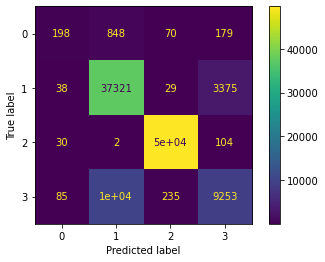

In [16]:
y_test_pred = adaboost.predict(X_test)
test_matrix = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(test_matrix).plot()

#### Training Data Set

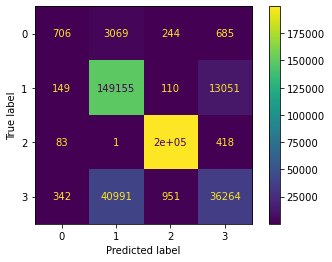

In [17]:
y_train_pred = adaboost.predict(X_train)
train_matrix = confusion_matrix(y_train, y_train_pred)
ConfusionMatrixDisplay(train_matrix).plot()

####  F-2 Scores

In [18]:
print(f'F_2 score of Adaboost on training dataset: {sklearn.metrics.fbeta_score(y_train, y_train_pred, beta=2, average="macro"):.4f}')
print(f'F_2 score of Adaboost on validation dataset: {sklearn.metrics.fbeta_score(y_test, y_test_pred, beta=2, average="macro"):.4f}')

F_2 score of Adaboost on training dataset: 0.6386
F_2 score of Adaboost on validation dataset: 0.6414


In [19]:
sklearn.metrics.fbeta_score(y_test, y_test_pred, beta=1, average=None)

array([0.24058323, 0.83914559, 0.99529266, 0.56941538])

In [20]:
import matplotlib.pyplot as plts

ranges = [2, 5, 10, 15, 20, 25, 30, 35, 40, 45]
training_accuracy = list()
test_accuracy = list()
training_f2score = list()
test_f2score = list()

for i in ranges:
    adaboost_overfit = AdaBoostClassifier(DecisionTreeClassifier(max_depth = i),n_estimators = 25, learning_rate = 1)
    adaboost_overfit.fit(X_train,y_train) 
    training_accuracy.append(adaboost_overfit.score(X_train,y_train))
    test_accuracy.append(adaboost_overfit.score(X_test,y_test))
    y_test_predict = adaboost.predict(X_test)
    y_train_predict = adaboost.predict(X_train)
    training_f2score.append(sklearn.metrics.fbeta_score(y_train, y_train_predict, beta=2, average="macro"))
    test_f2score.append(sklearn.metrics.fbeta_score(y_test, y_test_predict, beta=2, average="macro"))

# Scores for loaded tree size n = 50 Adaboost Classifier
training_accuracy.append(adaboost.score(X_train,y_train))
test_accuracy.append(adaboost.score(X_test,y_test))
training_f2score.append(sklearn.metrics.fbeta_score(y_train, y_train_pred, beta=2, average="macro"))
test_f2score.append(sklearn.metrics.fbeta_score(y_test, y_test_pred, beta=2, average="macro"))

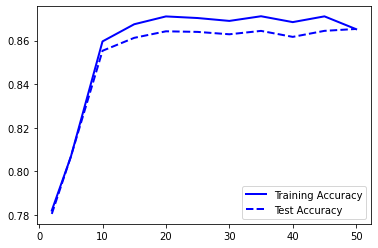

In [22]:
ranges.append(50)
dict_accuracy = {'Tree_Size': ranges, 'Training_Accuracy': training_accuracy, 'Test_Accuracy': test_accuracy, 'Training_F2': training_f2score, 'Test_F2': test_f2score}  
df = pd.DataFrame(dict_accuracy)
plts.plot( 'Tree_Size', 'Training_Accuracy', data=df, marker='', color='blue', linewidth=2, label="Training Accuracy")
plts.plot( 'Tree_Size', 'Test_Accuracy', data=df, marker='', color='blue', linewidth=2, linestyle='dashed', label="Test Accuracy")
plts.legend()

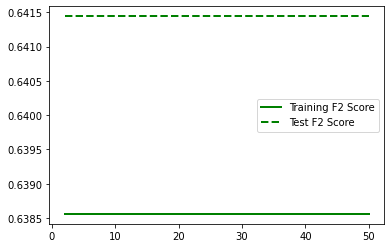

In [23]:
plts.plot( 'Tree_Size', 'Training_F2', data=df, marker='', color='green', linewidth=2, label="Training F2 Score")
plts.plot( 'Tree_Size', 'Test_F2', data=df, marker='', color='green', linewidth=2, linestyle='dashed', label="Test F2 Score")
plts.legend()